In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import sys
print(sys.executable)


/home/onizuka/Documents/Project M1/venv/bin/python3.10


In [14]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14',
       'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30',
       'Pct_Change', 'Log_Returns', 'Volatility_10', 'Volatility_30',
       'Future_Close', 'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [15]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [16]:
y = y.replace({2: 1})  # Replace '2' with '1'


In [17]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [20]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8700, 15)
y_train shape: (8700,)


In [21]:
## Light

In [22]:
from lightgbm import LGBMClassifier

# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Check if the model is a classifier
print(is_classifier(model))  # Should return True

NameError: name 'is_classifier' is not defined

In [23]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss instead of binary_error
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Num

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
## Hyperparameter

In [25]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Outlie

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] 

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [bin

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5892, number of negative: 2808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677241 -> initscore=0.741123
[LightGBM] [Info] Start training from score 0.741123
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}
Best Score: 0.7673563218390804


In [ ]:
##  Rebuild the model with Hyperparameters 

In [26]:
# Train the model with the best parameters
best_model = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5892, number of negative: 2808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677241 -> initscore=0.741123
[LightGBM] [Info] Start training from score 0.741123
Accuracy on Test Data with Tuned Parameters: 0.7894252873563219


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


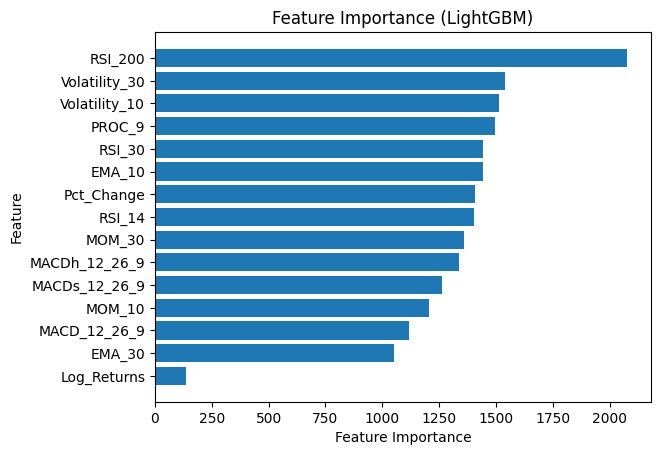

In [27]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = best_model.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


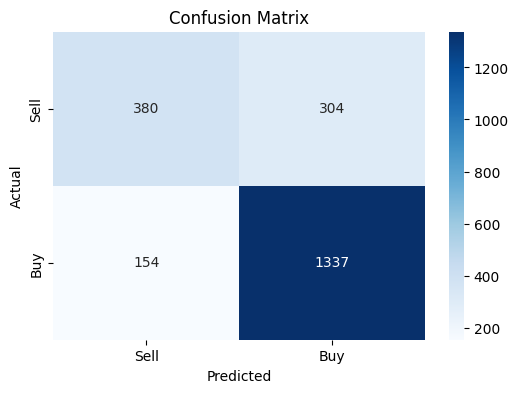

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
